# Reverse Game of Life - Z3 Constraint Satisfaction

[Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) is an example of 2D cellular automata. 

I have previously written an interactive playable demo of the forward version of this game:
- https://life.jamesmcguigan.com/

Using the classic ruleset on a 25x25 board with wraparound, the game evolves at each timestep according to the following rules
- Overpopulation: if a living cell is surrounded by more than three living cells, it dies.
- Stasis: if a living cell is surrounded by two or three living cells, it survives.
- Underpopulation: if a living cell is surrounded by fewer than two living cells, it dies.
- Reproduction: if a dead cell is surrounded by exactly three cells, it becomes a live cell.

Or expressed algebraically:
- living + 4-8 neighbours = dies
- living + 2-3 neighbours = lives
- living + 0-1 neighbour  = dies
- dead   +   3 neighbours = lives


To reverse the arrow of time:
- any living cell must have had living 2-3 neighbours in the previous timestep
- any dead cell must have had either 0-1 or 4-8 neighbours in the previous timestep
- any dead cell with distance of greater than 2 from a living cell can be ignored and assumed to have 0 neighbours
  - there are a near infinite number of self-contained patterns could have been born and died out in empty space
  - however for the sake of the competition, ignoring them will greatly reduce the search space


Whilst there have been many proposed solutions involving CNN neural networks (when all you have is a hammer, everything looks like a nail), this is in fact a classic constraint satisfaction problem. Here are some previous examples of using the Z3 library 
- https://www.kaggle.com/jamesmcguigan/z3-sudoku-solver
- https://www.kaggle.com/jamesmcguigan/cryptarithmetic-solver

We define a Z3 solver, with a 3d (= 2d + time) grid of t_cells, representing the current board state and
previous timesteps for the required delta to be solved.

As we are going backwards, we can ignore the rules for dead cells, and simply define
the constraints required for the past timestep to produce living cells in the current timestep.
We also define a rule to ignore any cells that currently have 0 neighbours
to reduce the search space and prevent zero-point energy solutions.

Kaggle Notebook:
- https://www.kaggle.com/jamesmcguigan/game-of-life-z3-constraint-satisfaction


In [1]:
import time

import numpy as np
import pandas as pd
import z3
from constraint_satisfaction.z3_solver import game_of_life_next_solution
from constraint_satisfaction.z3_solver import game_of_life_solver
from constraint_satisfaction.z3_solver import solve_dataframe
from util.plot import plot_3d
from util.util import csv_to_delta, csv_to_numpy, numpy_to_dict
from util.datasets import train_df, test_df

%load_ext autoreload
%autoreload 2

# Visualization of Solutions   

Here we show the first 10 solutions to the first (very simple) datapoint

game_of_life_solver() - took: 4.5s | Solved! 
game_of_life_next_solution() - took: 0.2s
game_of_life_next_solution() - took: 0.2s
game_of_life_next_solution() - took: 0.3s
game_of_life_next_solution() - took: 0.4s
game_of_life_next_solution() - took: 0.3s
game_of_life_next_solution() - took: 0.4s
game_of_life_next_solution() - took: 0.3s
game_of_life_next_solution() - took: 0.3s
game_of_life_next_solution() - took: 0.2s


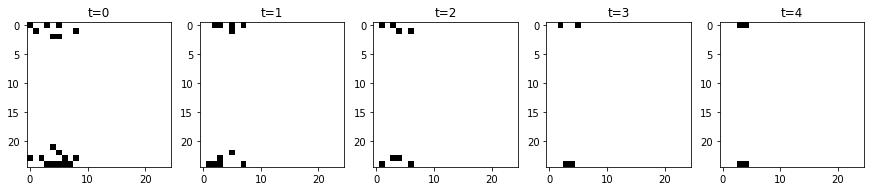

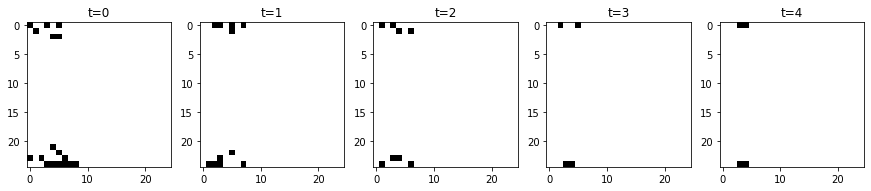

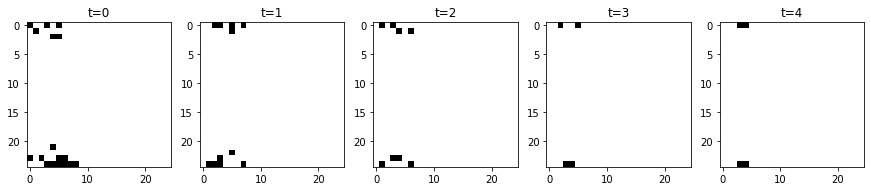

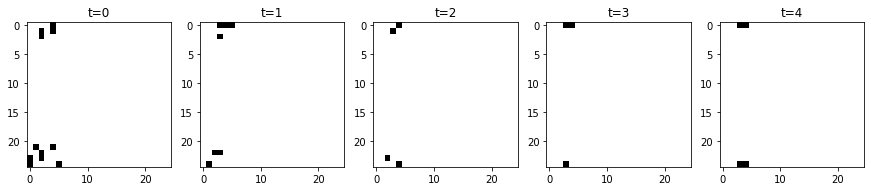

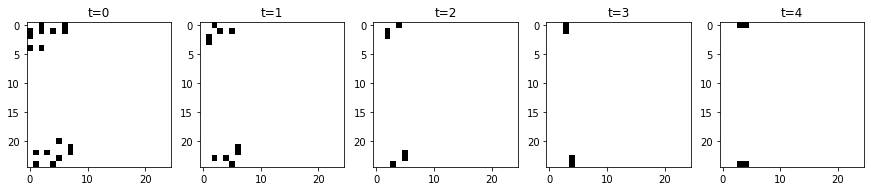

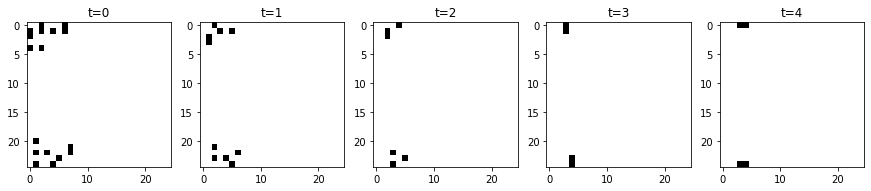

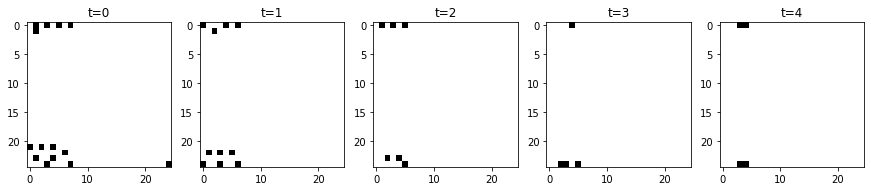

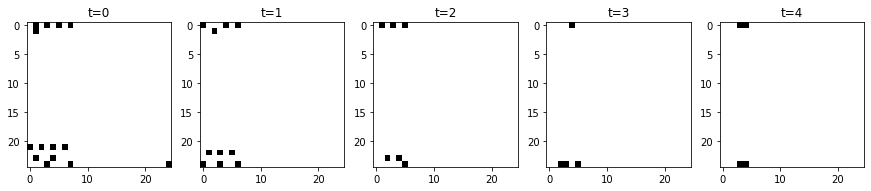

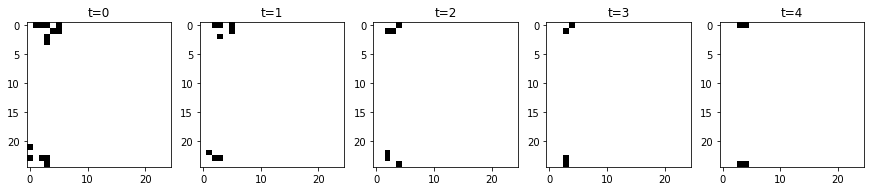

KeyboardInterrupt: 

In [2]:
idx      = 0   # delta = 3 - solved
delta    = csv_to_delta(train_df, idx)
board    = csv_to_numpy(train_df, idx, key='stop')
expected = csv_to_numpy(train_df, idx, key='start')

solution_count = 0
z3_solver, t_cells, solution_3d = game_of_life_solver(board, delta)
time_start = time.perf_counter()
while np.count_nonzero(solution_3d):
    solution_count += 1
    verbose = solution_count < 10
    if verbose: plot_3d(solution_3d)
    z3_solver, t_cells, solution_3d = game_of_life_next_solution(z3_solver, t_cells, verbose=verbose) # takes ~0.5s per solution
print(f'Total Solutions: {solution_count} in {time.perf_counter() - time_start:.1f}s')


# Test Dataset

grids with fewer cells are exponentially easier and quicker to solve

In [5]:
df = test_df[:100]
df = df.iloc[ df.apply(np.count_nonzero, axis=1).argsort() ]
print(list(df.index[:10]))

[50055, 50018, 50004, 50022, 50033, 50048, 50072, 50007, 50070, 50080]


test_df.loc[50055] | delta = 3 | cells = 4 | time =  4.7s
test_df.loc[50018] | delta = 1 | cells = 4 | time =  1.6s
test_df.loc[50004] | delta = 3 | cells = 4 | time =  4.6s
test_df.loc[50022] | delta = 3 | cells = 6 | time =  6.2s
test_df.loc[50033] | delta = 3 | cells = 6 | time =  5.8s
test_df.loc[50048] | delta = 2 | cells = 6 | time =  3.0s
test_df.loc[50072] | delta = 3 | cells = 8 | time =  5.4s
test_df.loc[50007] | delta = 2 | cells = 8 | time =  2.8s
test_df.loc[50070] | delta = 3 | cells = 8 | time =  8.3s
test_df.loc[50080] | delta = 2 | cells = 11 | time =  3.8s


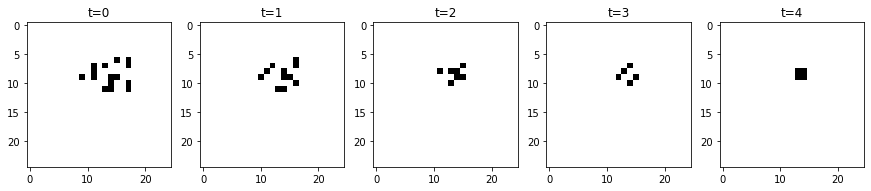

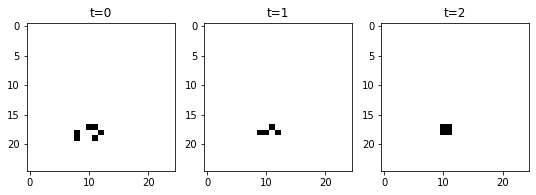

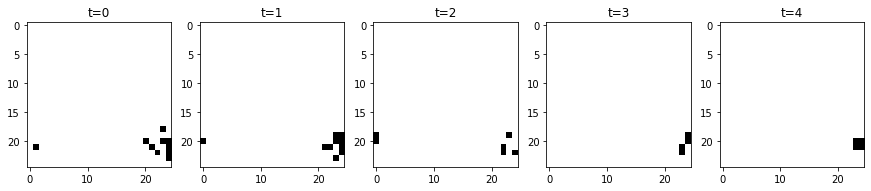

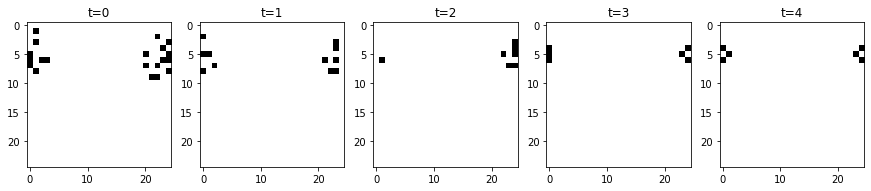

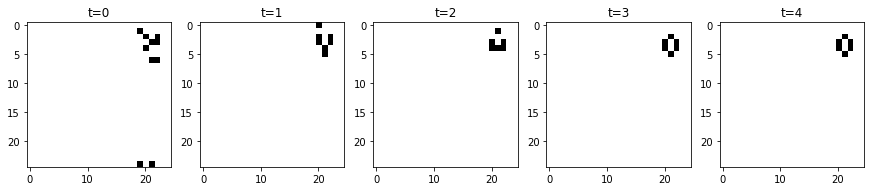

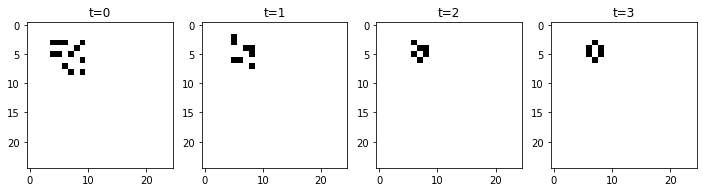

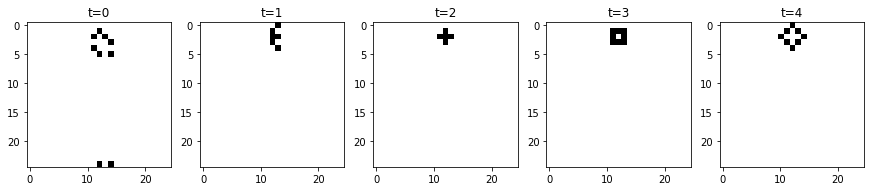

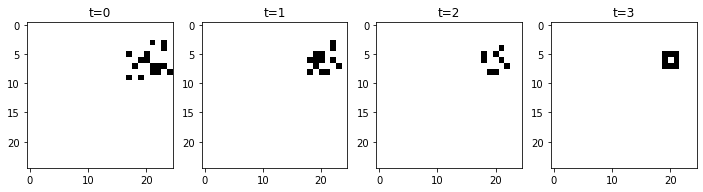

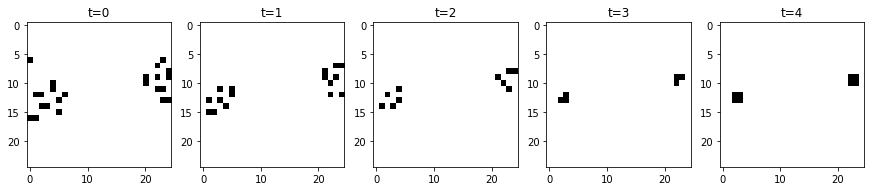

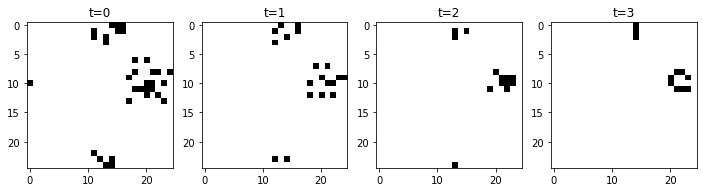

In [6]:
for idx in df.index[:10]:
    time_start = time.perf_counter()

    delta = csv_to_delta(df, idx)
    board = csv_to_numpy(df, idx, key='stop')
    z3_solver, t_cells, solution_3d = game_of_life_solver(board, delta, verbose=False)

    time_taken = time.perf_counter() - time_start
    print(f'test_df.loc[{idx}] | delta = {delta} | cells = {np.count_nonzero(board)} | time = {time_taken:4.1f}s')
    plot_3d(solution_3d)

